In [2]:
import numpy as np
from scipy.sparse import linalg as lg
import exact_diagonalization as ed
import utils
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

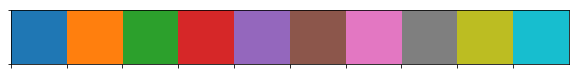

In [3]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["font.size"] = 20

cp = sns.color_palette()
sns.palplot(cp)
plt.show()

Set parameters and calculate exact evolutions

In [5]:
n_sites = 4
time_steps = 50
h_init = 1.0
h_ev = 0.5

t = np.linspace(0.0, 1.0, time_steps + 1)
dt = t[1] - t[0]

ham = utils.tfim_hamiltonian(n_sites, h=h_ev)
exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

Construct clock without penalty term and solve the system to find evolution

In [6]:
clock = ed.construct_sparse_clock(ham, dt, time_steps)
system_state = ed.solve_evolution_system(clock, exact_state[0], lg.gmres)
print(system_state.shape)

print("Overlap with exact: {}".format(utils.overlap(exact_state, system_state)))
print("Average overlap with exact: {}".format(utils.averaged_overlap(exact_state, system_state)))

Convergence status: 0
(51, 16)
Overlap with exact: 0.9999495483074702
Average overlap with exact: 0.9999824413222875


Repeat for various values of $T$

In [7]:
T_list = np.arange(20, 340, 20)
t_final_list = [1.0, 1.5, 2.0]

overlaps = []
for t_final in t_final_list:
    overlaps.append({"full": [], "averaged": []})
    for time_steps in T_list:
        t = np.linspace(0.0, t_final, time_steps + 1)
        dt = t[1] - t[0]
        exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
        clock = ed.construct_sparse_clock(ham, dt, time_steps)
        system_state = ed.solve_evolution_system(clock, exact_state[0], lg.gmres, print_info=False)
        overlaps[-1]["full"].append(utils.overlap(exact_state, system_state))
        overlaps[-1]["averaged"].append(utils.averaged_overlap(exact_state, system_state))
        print(".", end="")
    for k in overlaps[-1].keys():
        overlaps[-1][k] = np.array(overlaps[-1][k])
    print()

................
................
................


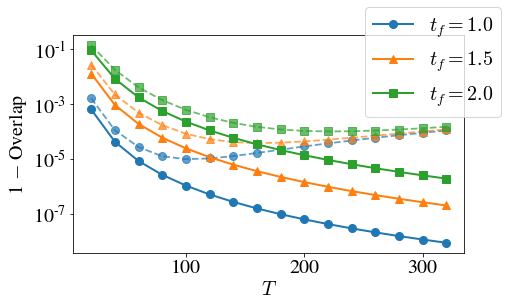

In [22]:
plt.figure(figsize=(7, 4))
markers = ["o", "^", "s"]
for i, t_final in enumerate(t_final_list):
    plt.semilogy(T_list, 1 - overlaps[i]["averaged"], marker=markers[i], linewidth=2.0, markersize=8, color=cp[i], label="$t_f=%.1f$"%t_final)
    plt.semilogy(T_list, 1 - overlaps[i]["full"], "--", marker=markers[i], linewidth=1.8, markersize=8, color=cp[i], alpha=0.7)
plt.xlabel("$T$")
plt.ylabel("1 $-$ Overlap")
plt.legend(loc="lower left", bbox_to_anchor=(0.72, 0.58), fontsize=20)
#plt.show()
plt.savefig("ed_overlaps_steps.pdf", bbox_inches='tight')

Solve eigenvalue problem for Hamiltonian with penalty term

In [19]:
n_sites = 4
h_init = 1.0
h_ev = 0.5
time_steps = 20
penalty = 10.0

t = np.linspace(0.0, 3.0, time_steps + 1)
dt = t[1] - t[0]
exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
ham = utils.tfim_hamiltonian(n_sites, h=h_ev)
clock = ed.construct_sparse_clock(ham, dt, time_steps)

clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
clock_pen = np.array(clock_pen.todense())

system_state = ed.solve_evolution_system(clock, exact_state[0], lg.gmres)
eigvals, eigvecs = np.linalg.eigh(clock_pen)
eig_state = eigvecs[:, 0].reshape(exact_state.shape)

print("Penalty: {}".format(penalty))
print("\nSystem - Exact: {}".format(utils.averaged_overlap(exact_state, system_state)))
print("Eig - Exact: {}".format(utils.averaged_overlap(exact_state, eig_state)))
print("System - Eig: {}".format(utils.averaged_overlap(eig_state, system_state)))

clock_ev = lambda state: state.ravel().conj().dot(clock_pen.dot(state.ravel())) / (np.abs(state)**2).sum()
print("\nClock EVs:")
print("Exact: {}".format(clock_ev(exact_state)))
print("System: {}".format(clock_ev(system_state)))
print("Eig: {}".format(clock_ev(eig_state)))

Convergence status: 0
Penalty: 10.0

System - Exact: 0.5515175297584666
Eig - Exact: 6.0902642218166844e-24
System - Eig: 6.267117672764493e-24

Clock EVs:
Exact: (0.03478907027650905+1.0573552615477664e-17j)
System: (0.034707893080177125-2.765810748728232e-18j)
Eig: (0.005811628078718459-3.903127820947815e-18j)


Check how changing the penalty coefficient affects the overlap between exact and lowest eigenstate

In [4]:
n_sites = 4
h_init = 1.0
h_ev = 0.5
time_steps = 60
penalty_list = np.linspace(1e-2, 10, 30)

t = np.linspace(0.0, 1.0, time_steps + 1)
dt = t[1] - t[0]
exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
ham = utils.tfim_hamiltonian(n_sites, h=h_ev)

overlaps = {"full": [], "averaged": []}
for penalty in penalty_list:
    clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
    clock_pen = np.array(clock_pen.todense())

    eigvals, eigvecs = np.linalg.eigh(clock_pen)
    eig_state = eigvecs[:, 0].reshape(exact_state.shape)
    
    overlaps["full"].append(utils.overlap(exact_state, eig_state))
    overlaps["averaged"].append(utils.averaged_overlap(exact_state, eig_state))
    print(".", end="")

for k in overlaps.keys():
    overlaps[k] = np.array(overlaps[k])

..

KeyboardInterrupt: 

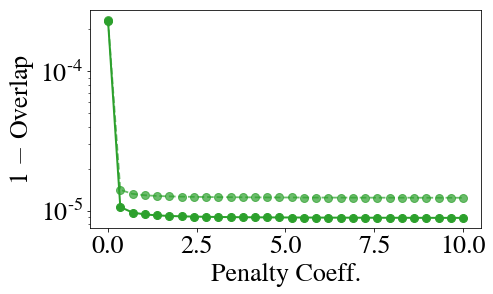

In [60]:
for k in overlaps.keys():
    overlaps[k] = np.array(overlaps[k])
    n = len(overlaps[k])
    
plt.figure(figsize=(7, 4))
plt.semilogy(penalty_list[:n], 1 - overlaps["averaged"], marker="o", linewidth=2.0, markersize=8, color=cp[2])
plt.semilogy(penalty_list[:n], 1 - overlaps["full"], "--", marker="o", linewidth=1.8, markersize=8, color=cp[2], alpha=0.7)
plt.xlabel("Penalty Coeff.")
plt.ylabel("1 $-$ Overlap")
plt.show()

we see that if the penalty value is large enough, then it does not affect the physics. Hence, it is okay to use a large constant penalty.

Check how the gap changes as a function of $T$ and $t$ for constant penalty. Notice that there is a **critical** $dt$ after which the system becomes "gapless" and solving the system or diagonalizing the Clock Hamiltonian does not give the correct evolution (we can check that by calculating the corresponding overlaps above).

In [37]:
n_sites = 4
h_init = 1.0
h_ev = 0.5
t_final_list = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
T_list = np.arange(1, 20)
penalty = 1000.0

gaps = []
for t_final in t_final_list:
    gaps.append([])
    for time_steps in T_list:
        t = np.linspace(0.0, t_final, time_steps + 1)
        dt = t[1] - t[0]
        exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

        clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
        clock_pen = np.array(clock_pen.todense())

        eigvals = np.linalg.eigvalsh(clock_pen)
        gaps[-1].append(eigvals[1] - eigvals[0])

        print(".", end="")
    print()

...................
...................
...................
...................
...................
...................


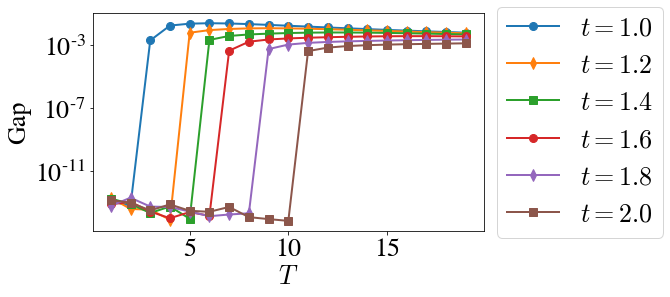

In [38]:
plt.figure(figsize=(7, 4))
markers = 3 * ["o", "d", "s"]

for i, t_final in enumerate(t_final_list):
    plt.semilogy(T_list, gaps[i], marker=markers[i], linewidth=2.0, markersize=8, color=cp[i], label="$t=%.1f$"%t_final)
plt.xlabel("$T$")
plt.ylabel("Gap")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Repeat the same plot but for proper $dt$s so that the method works well

..........
..........
..........
..........
..........


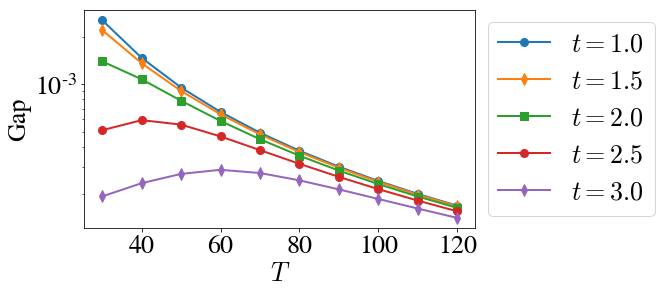

In [40]:
n_sites = 4
h_init = 1.0
h_ev = 0.5
t_final_list = [1.0, 1.5, 2.0, 2.5, 3.0]
T_list = np.arange(30, 130, 10)
penalty = 10.0

gaps = []
for t_final in t_final_list:
    gaps.append([])
    for time_steps in T_list:
        t = np.linspace(0.0, t_final, time_steps + 1)
        dt = t[1] - t[0]
        exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

        clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
        clock_pen = np.array(clock_pen.todense())

        eigvals = np.linalg.eigvalsh(clock_pen)
        gaps[-1].append(eigvals[1] - eigvals[0])

        print(".", end="")
    print()
    
plt.figure(figsize=(7, 4))
markers = 3 * ["o", "d", "s"]

for i, t_final in enumerate(t_final_list):
    plt.semilogy(T_list, gaps[i], marker=markers[i], linewidth=2.0, markersize=8, color=cp[i], label="$t_f=%.1f$"%t_final)
plt.xlabel("$T$")
plt.ylabel("Gap")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()